In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats
import math

In [2]:
cd CSVs

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1/CSVs


#### Load Data

In [3]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])
data


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,00:00:00,REGULAR,7053483,2390505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,04:00:00,REGULAR,7053511,2390508
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,08:00:00,REGULAR,7053534,2390536
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,12:00:00,REGULAR,7053618,2390596
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,16:00:00,REGULAR,7053841,2390655
...,...,...,...,...,...,...,...,...,...,...,...
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,05:00:00,REGULAR,5554,376
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,09:00:00,REGULAR,5554,376
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,13:00:00,REGULAR,5554,376
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,17:00:00,REGULAR,5554,376


### Clean Data

remove spaces from column names

In [4]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [5]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [6]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

#### Find total traffic

Add shifted columns to show previous entries and exits

In [7]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
#grouped_time.head()

In [8]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True) 

Remove counter errors from total entries/exits that occur from counters resetting

In [9]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [10]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=1000000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=1000000)

In [11]:
#find total traffic
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [12]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering

drop uneeded columns

In [13]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME','DESC', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS', 'TOTAL_ENTRIES', 'TOTAL_EXITS'], axis=1, inplace=True)

/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
#grouped_day = data.groupby(['DATE','Turnstile','STATION'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = data.groupby(['STATION','DATE']).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = grouped.set_index('STATION')
#grouped.head()

In [15]:
#grouped_day.head()

In [16]:
#grouped.columns = [ 'Station', 'Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped_day.columns = [ 'Date', 'Turnstile', 'Station','ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.columns = ['ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.dtypes

Find total entries exits, and traffic

In [17]:
#grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
#grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
#grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Entries']
#grouped_day.head()

In [18]:
#grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)



Removing Outlier data from Total_traffic column (Removing anything outside 3 sigma)

In [19]:
#grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

#### Combine data

### Finding top 10 visited stations

In [20]:
Total_ridership = grouped_day.groupby(['Station']).Total_Traffic.sum().reset_index()

NameError: name 'grouped_day' is not defined

In [ ]:
Total_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)


In [ ]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.Total_Traffic 
    station_list = rows.Station
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(10)


In [ ]:
plt.ylim(10000000,21000000)
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.title("Total traffic for the period for top 10 busiest stations")
plt.bar(indices, Row_list)

Top 10 Busy Stations, We will focus on top5 of these.

In [ ]:
indices

### Find high traffic days

In [ ]:
Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.sum().reset_index()
#Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.mean().reset_index()
Total_Weekly_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)
Total_Weekly_ridership.head()

In [ ]:
#plt.ylim(1610000000000,1620000000000)
plt.ylim(40000000,140000000)
plt.bar(Total_Weekly_ridership['Week_Day'], Total_Weekly_ridership['Total_Traffic'])

Based on this it seems like weekends see much less traffic compared to weekdays. So WWTF should focus more on weekdays 

In [ ]:
Top5 = Total_ridership['Station'][0:5].tolist()
Top5_stations = grouped_day[grouped_day['Station'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['Station','Date']).Total_Traffic.sum().reset_index()
#Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.mean().reset_index()

#### Weekly Plot for Top5 stations

In [ ]:

for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
    plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()



Looking at the plot seems like top5 stations are also showing a dip on weekends, but PATH NEW WTC station is oblitrating seeing the trend properly. This needs to be investigated further. Also, to see the trend for rest of the station we will do another plot removing the data for PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
        plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This is also showing the dip in weekend more clearly. But GRD CNTRL-42 ST shows peak on thursday - which needs to be investigated.

In [ ]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
    plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot is also showing some abnormal values for some of the days for PATH NEW WTC. Two of these dates are looking on thursdays. We will look at rest of the stations removing PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
        plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot also seems to have some outliers. But In general trend is clear Traffic takes a dip on weekends and remains kind of static on weekdays

### Find peak hours

### Find high traffic areas for games

### Compare Boroughs

read location data to get borough info and latitude/longitude information

In [42]:
loc_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
#print(loc_data.Borough.unique())
loc_df.tail()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Notes
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville,0,NaN
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville,0,NaN
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville,0,NaN
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN,1,NaN
495,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,St George,Tottenville,1,NaN


In [43]:
#add borough_name column
burough_dict = { 'Q': 'Queens', 'M': 'Manhattan', 'Bk':'Brooklyn', 'Bx': 'Bronx', 'SI': 'Staten Island'}
loc_df['Borough_Name'] = loc_df['Borough'].map(burough_dict)

In [44]:
#drop uneeded columns
loc_df.drop(['Borough','Line','Station ID','Complex ID', 'GTFS Stop ID', 'Line', 'Structure', 
               'Daytime Routes', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Notes'], axis=1, inplace =True)

Rename columns in loc_data to merge on STATION and DIVISION

In [45]:
#stations were found to have the same but located in diff areas so DIVISION was also used
loc_df.rename(columns = {'Stop Name':'STATION', 'Division':'DIVISION','GTFS Latitude':'Latitude','GTFS Longitude':'Longitude'}, inplace = True) 
loc_df['STATION'] = loc_df['STATION'].str.upper()
#join with grouped_time
station_loc_df = grouped_time.merge(loc_df, how = 'inner', on = ['STATION'])
station_loc_df.tail()
print(station_loc_df[station_loc_df['STATION']=='28 ST'])

       STATION DIVISION_x       DATE      TIME           Date_Time  \
214527   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
214528   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
214529   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
214530   28 ST        BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
214531   28 ST        BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
...        ...        ...        ...       ...                 ...   
268249   28 ST        IRT 2019-05-03  17:00:00 2019-05-03 17:00:00   
268250   28 ST        IRT 2019-05-03  17:00:00 2019-05-03 17:00:00   
268251   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   
268252   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   
268253   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   

                    Turnstile  Week_Day  TOTAL_TRAFFIC DIVISION_y   Latitude  \
214527  A027R08201-00-0028 ST  Saturday           87.0        BMT  40.745494   

#### Graph number of stations in each borough

<BarContainer object of 5 artists>

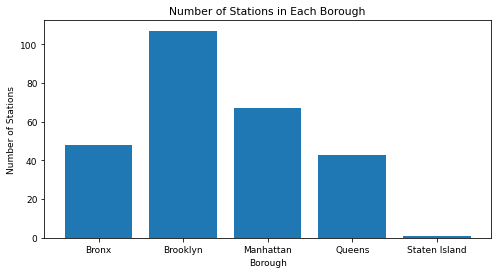

In [46]:
borough_station_count_df = station_loc_df.groupby('Borough_Name')['STATION'].nunique().reset_index()
#borough_station_count_df
plt.rcParams["figure.figsize"] = (8, 4)
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.title("Number of Stations in Each Borough")
plt.bar(borough_station_count_df['Borough_Name'], borough_station_count_df['STATION'])

#### Graph total traffic in each Borough 

<BarContainer object of 5 artists>

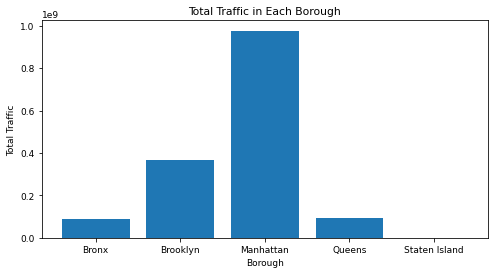

In [47]:
borough_traffic_df = station_loc_df.groupby('Borough_Name').TOTAL_TRAFFIC.sum().reset_index()
plt.xlabel("Borough")
plt.ylabel("Total Traffic")
plt.title("Total Traffic in Each Borough")
plt.bar(borough_traffic_df['Borough_Name'], borough_traffic_df['TOTAL_TRAFFIC'])
#borough_traffic_df

### Find top stations in each borough

#### Find top 5 stations in each borough and graph

In [48]:
borough_top5_df = station_loc_df.groupby(['Borough_Name','STATION']).agg({'TOTAL_TRAFFIC':'sum'})
borough_top5_df = borough_top5_df['TOTAL_TRAFFIC'].groupby('Borough_Name', group_keys=False)
borough_top5_df = borough_top5_df.apply(lambda x: x.sort_values(ascending=False).head(5))
borough_top5_df

Borough_Name   STATION       
Bronx          KINGSBRIDGE RD     7020950.0
               FORDHAM RD         6616000.0
               167 ST             6341490.0
               170 ST             6088568.0
               GUN HILL RD        4758304.0
Brooklyn       86 ST             33514096.0
               CHURCH AV         23167353.0
               FULTON ST         20067033.0
               KINGS HWY         18236364.0
               7 AV              13239594.0
Manhattan      23 ST             91625880.0
               CANAL ST          86327352.0
               FULTON ST         80268132.0
               86 ST             67028192.0
               TIMES SQ-42 ST    66897292.0
Queens         COURT SQ           9475596.0
               WOODHAVEN BLVD     8141652.0
               111 ST             7807929.0
               QUEENS PLAZA       4180325.0
               36 ST              3948116.0
Staten Island  TOMPKINSVILLE       247600.0
Name: TOTAL_TRAFFIC, dtype: float64

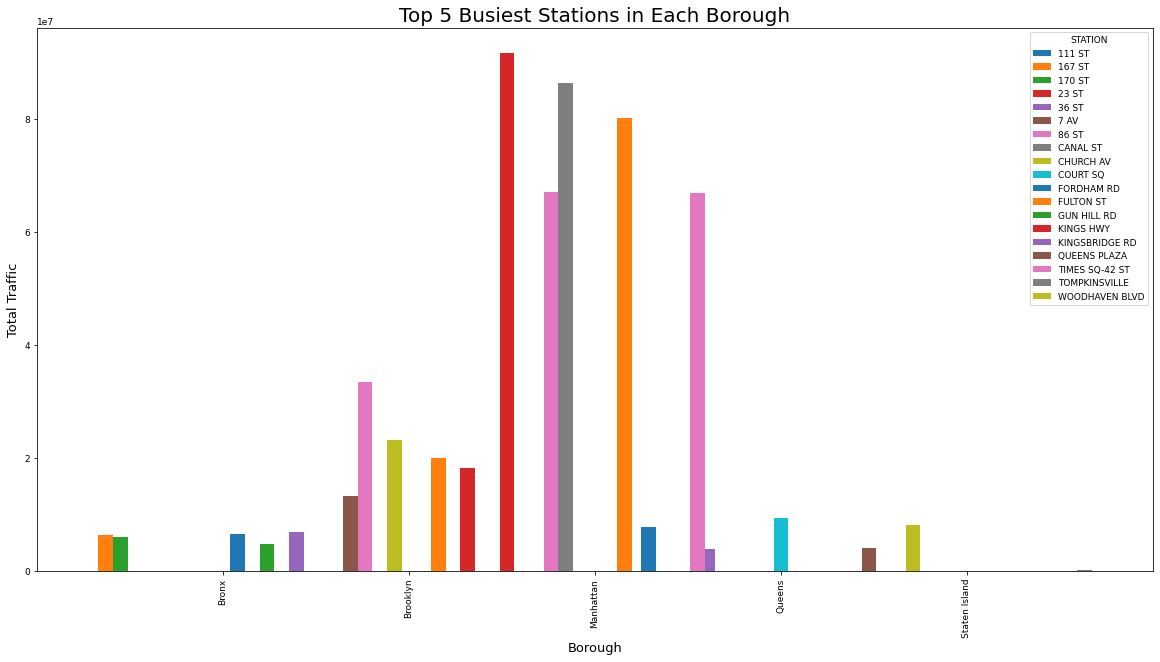

In [49]:
rcParams['figure.figsize'] = 20,10
borough_top5_df.unstack().plot.bar(width=1.5)
#plt.bar([0,2,3,4],borough_top5_df.unstack(),width=1.5)
#plt.bar(borough_top5_df.unstack(),width=1.5)
plt.title("Top 5 Busiest Stations in Each Borough", fontsize=20)
plt.ylabel("Total Traffic",fontsize=13)
plt.xlabel("Borough",fontsize=13)
plt.rcParams.update({'font.size': 9})
#plt.tight_layout()
 
#borough_top5_df.unstack().plot.bar()

### Find stations in the highest income areas

In [29]:
#import income data
income_data = pd.read_csv('https://raw.githubusercontent.com/hollyyuqizheng/transportation-transformation/master/data/new_york/new%20york%20income%20data.csv')
#print(loc_data.Borough.unique())
income_data.head()

,Zip Code,Location,City,Avg. Income/H/hold,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,10007,"40.713973, -74.008336","New York, New York",112947,NaN,NaN,NaN
1,10280,"40.708501, -74.016828","New York, New York",108536,NaN,NaN,NaN
2,10162,"40.769298, -73.949942","New York, New York",108416,NaN,NaN,NaN
3,10004,"40.691870, -74.014109","New York, New York",101868,NaN,NaN,NaN
4,10069,"40.775551, -73.989689","New York, New York",88091,NaN,NaN,NaN


In [30]:
#new df grouped by latitude, longitude, and station
#station_lat_long_df = station_loc_df.groupby(['STATION','Borough_Name'], as_index=False ).agg({'Latitude':'mean','Longitude':'mean','TOTAL_TRAFFIC':'count'})
station_lat_long_df = station_loc_df.groupby(['Latitude','Longitude', 'STATION','Borough_Name'], as_index=False ).TOTAL_TRAFFIC.sum()
#station_lat_long_df.drop_duplicates('STATION',keep='first', inplace=True)
#print(station_lat_long_df[station_lat_long_df['STATION']=='28 ST'])

#station_lat_long_df.duplicated(subset=['STATION']) 
#print(station_lat_long_df[station_lat_long_df['STATION']==True])

Find average income for each station

In [31]:
#row from station_income_df as argument
#loop through income_df to find closest zip code based on latitude and longitude
#return Avg income of closest zip code to station
def find_min_dist(row):
    min_dist = 1000
    idx = 0
    for index, r in income_data.iterrows():
        l = r[1].split(", ")
        l = [float(i) for i in l]
        a = ((l[0] - row['Latitude'])**2 + (l[1] - row['Longitude'])**2)
        a = abs(a)
        dist = math.sqrt(a)
        if dist < min_dist:
            min_dist = dist
            idx = index
    return income_data.iloc[idx]['Avg. Income/H/hold']

In [32]:
station_income_df = station_lat_long_df.copy()
station_income_df['Avg_Income'] = station_income_df.apply(find_min_dist, axis=1)
station_income_df.sort_values('Avg_Income', ascending=False, inplace=True)
station_income_df.head(10)
station_income_df.duplicated(subset=['STATION']) 
print(station_income_df[station_income_df['STATION']==True])

Empty DataFrame
Columns: [Latitude, Longitude, STATION, Borough_Name, TOTAL_TRAFFIC, Avg_Income]
Index: []


    Borough_Name          STATION  Avg_Income  TOTAL_TRAFFIC
251    Manhattan       5 AV/59 ST    9925.825      3250952.0
248    Manhattan             7 AV    1920.137      6619797.0
242    Manhattan            49 ST    1920.137      4355113.0
216    Manhattan            28 ST     775.718      9436731.0
229    Manhattan  34 ST-HERALD SQ     775.718     19239746.0
227    Manhattan  34 ST-HERALD SQ     775.718     19239746.0
223    Manhattan            28 ST     775.718      9436731.0
210    Manhattan            23 ST     775.718     18325176.0
145    Manhattan         BROAD ST     683.269      2314135.0
151    Manhattan          WALL ST     683.269     11057493.0
    Borough_Name          STATION  Avg_Income  TOTAL_TRAFFIC
114     Brooklyn        FULTON ST       49567     20067033.0
156    Manhattan        FULTON ST       31316     20067033.0
159    Manhattan        FULTON ST      205192     20067033.0
157    Manhattan        FULTON ST      205192     20067033.0
158    Manhattan        

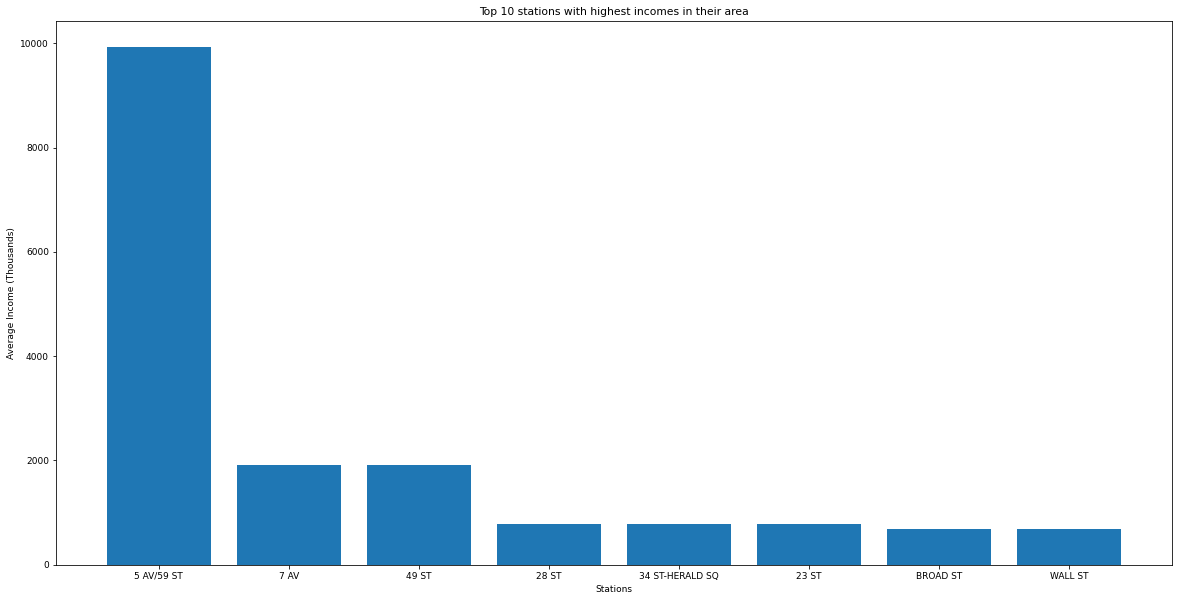

In [33]:
top_station_income_df = station_income_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)
top_station_income_df['Avg_Income'] = top_station_income_df['Avg_Income']/1000
#top_station_income_df.duplicated(subset=['STATION']) 
#print(top_station_income_df[top_station_income_df['STATION']==True])
#print(top_station_income_df[top_station_income_df['STATION']=='28 ST'])
plt.xlabel("Stations")
plt.ylabel("Average Income (Thousands)")
plt.title("Top 10 stations with highest incomes in their area")
plt.bar(top_station_income_df['STATION'], top_station_income_df['Avg_Income'])

top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
top_traffic_stations_df = top_traffic_stations_df.head(10)
print(top_station_income_df )
print(top_traffic_stations_df )

In [34]:
top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
top_traffic_stations_df = top_traffic_stations_df.head(10)

<BarContainer object of 10 artists>

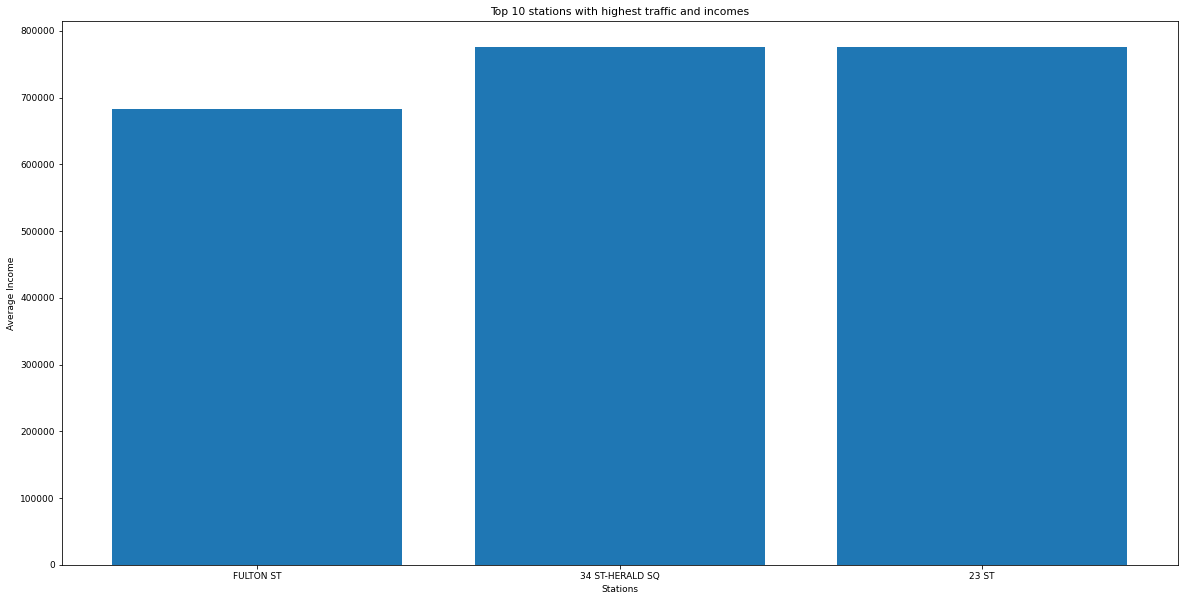

In [35]:
plt.xlabel("Stations")
plt.ylabel("Average Income")
plt.title("Top 10 stations with highest traffic and incomes")
plt.bar(top_traffic_stations_df['STATION'], top_traffic_stations_df['Avg_Income'])

In [50]:
#find max and min of lat and long
BBox = (station_lat_long_df.Longitude.min(),   station_lat_long_df.Longitude.max(),      
         station_lat_long_df.Latitude.min(), station_lat_long_df.Latitude.max())
BBox

(-74.074835, -73.761353, 40.576312, 40.898379)

In [53]:
cd - 

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1


In [54]:
ruh_m = plt.imread('NYC_Map.png') #load NYC Map

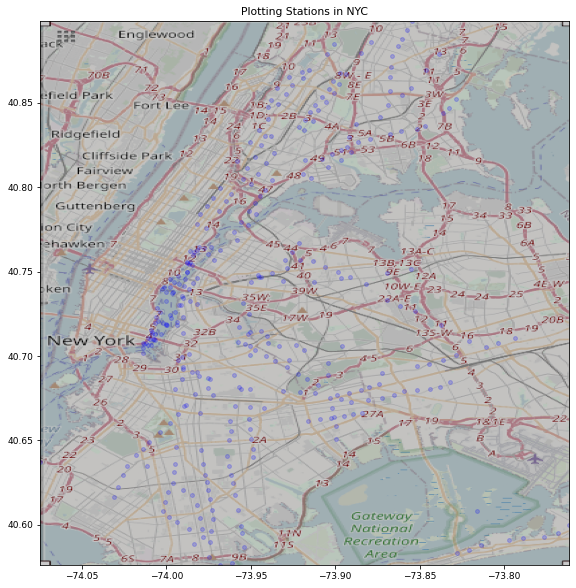

In [55]:
fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(station_lat_long_df.Longitude, station_lat_long_df.Latitude, zorder=1, alpha= 0.2, c='b', s=15)
ax.set_title('Plotting Stations in NYC')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')